In [1]:
from main import *
from models import *
from hyperparameter import *

2024-09-29 15:48:30.878787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 15:48:30.890927: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 15:48:30.894415: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1727617712.223489   58404 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727617712.253120   58404 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have be

# Preprocessing, Visualization, and Train/Val/Test Split

In [2]:
data_dir ='data' # Change to the path to your directory
train_images_dir = os.path.join(data_dir, 'Training')
test_images_dir = os.path.join(data_dir, 'Testing')
print(f"Data directory: {data_dir}")
print(f"Training directory: {train_images_dir}")
print(f"Testing directory: {test_images_dir}")

Data directory: data
Training directory: data/Training
Testing directory: data/Testing


In [3]:
# Load the training and test data
try:
    train_data, test_data = get_images(train_images_dir, test_images_dir)
    print("Data loading completed successfully.")
    print(f"Number of training samples: {train_data.samples}")
    print(f"Number of test samples: {test_data.samples}")
    print(f"Class names: {train_data.class_indices}")
except Exception as e:
    print(f"Error loading data: {e}")
    raise

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Data loading completed successfully.
Number of training samples: 5712
Number of test samples: 1311
Class names: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [4]:
class_names_train = list(train_data.class_indices.keys())
class_names_test = list(test_data.class_indices.keys())

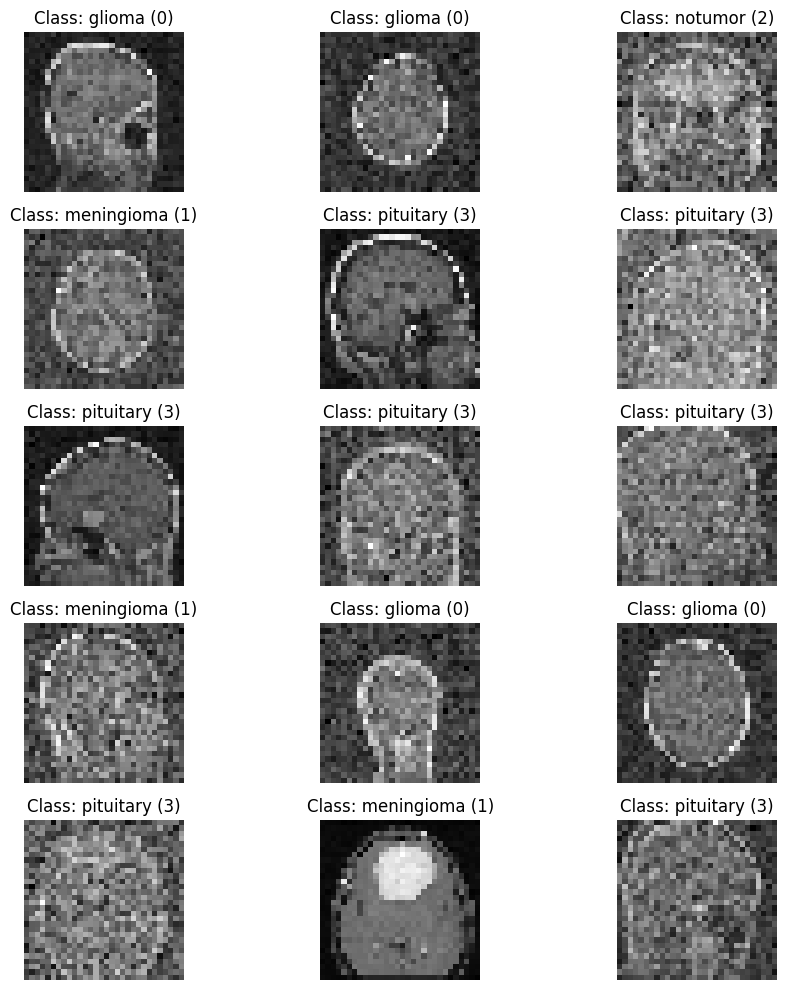

In [5]:
visualize_batch(train_data)

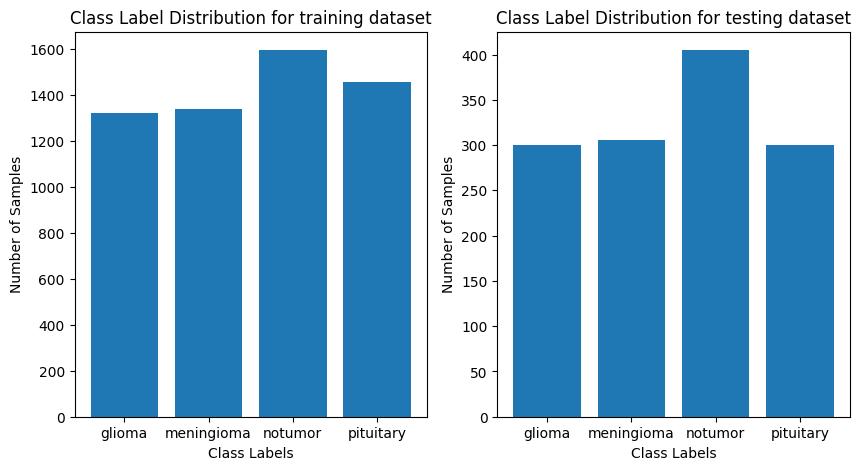

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
plot_class_dist(ax1, train_data, "training")
plot_class_dist(ax2, test_data, "testing")

In [7]:
X_train, y_train, X_val, y_val = train_val_split(train_data)
X_test, y_test = test_splits(test_data)

Number of batches in the training data: 179
Batch size of a single batch 32
Number of samples in the training dataset 5712

Number of training data batches with val split of 0.2: 144
Number of validation data batches: 35

Shape of image training set: (4608, 30, 30, 1)
Shape of image validation set: (1104, 30, 30, 1)

Shape of label training set: (4608, 4)
Shape of label validation set: (1104, 4)
Number of batches in the test data: 41
Batch size of a single batch 32
Number of samples in the test dataset 1311

Shape of image test set: (1311, 30, 30, 1)

Shape of label test set: (1311, 4)


# Baseline Model

In [8]:
base = baseline()
history = base.fit(X_train, y_train, batch_size =32, epochs = 10, validation_data = (X_val, y_val))

Epoch 1/10


I0000 00:00:1727617720.874152   58467 service.cc:146] XLA service 0x7fb5ac002120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727617720.874201   58467 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6


 43/144 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - F1Score: 0.2061 - accuracy: 0.3071 - gioma_precision: 0.0601 - gioma_recall: 0.0023 - loss: 1.3244 - meningioma_precision: 0.0000e+00 - meningioma_recall: 0.0000e+00 - notumor_precision: 0.5182 - notumor_recall: 0.0497 - pituitary_precision: 0.1223 - pituitary_recall: 0.0067                      

I0000 00:00:1727617723.605393   58467 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


144/144 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - F1Score: 0.3947 - accuracy: 0.4399 - gioma_precision: 0.4481 - gioma_recall: 0.1204 - loss: 1.1781 - meningioma_precision: 0.3216 - meningioma_recall: 0.0161 - notumor_precision: 0.7774 - notumor_recall: 0.2752 - pituitary_precision: 0.5277 - pituitary_recall: 0.2135 - val_F1Score: 0.6372 - val_accuracy: 0.6630 - val_gioma_precision: 0.8105 - val_gioma_recall: 0.4733 - val_loss: 0.8990 - val_meningioma_precision: 0.9286 - val_meningioma_recall: 0.0522 - val_notumor_precision: 0.9000 - val_notumor_recall: 0.6235 - val_pituitary_precision: 0.6196 - val_pituitary_recall: 0.9425
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - F1Score: 0.7011 - accuracy: 0.7106 - gioma_precision: 0.7337 - gioma_recall: 0.5469 - loss: 0.7789 - meningioma_precision: 0.6722 - meningioma_recall: 0.2846 - notumor_precision: 0.8822 - notumor_recall: 0.7200 - pituitary_precision: 0.7963 - pituitary_recall: 0.7729 - val_F1Score: 0.7312 - val_accuracy: 0.7364 - val_g

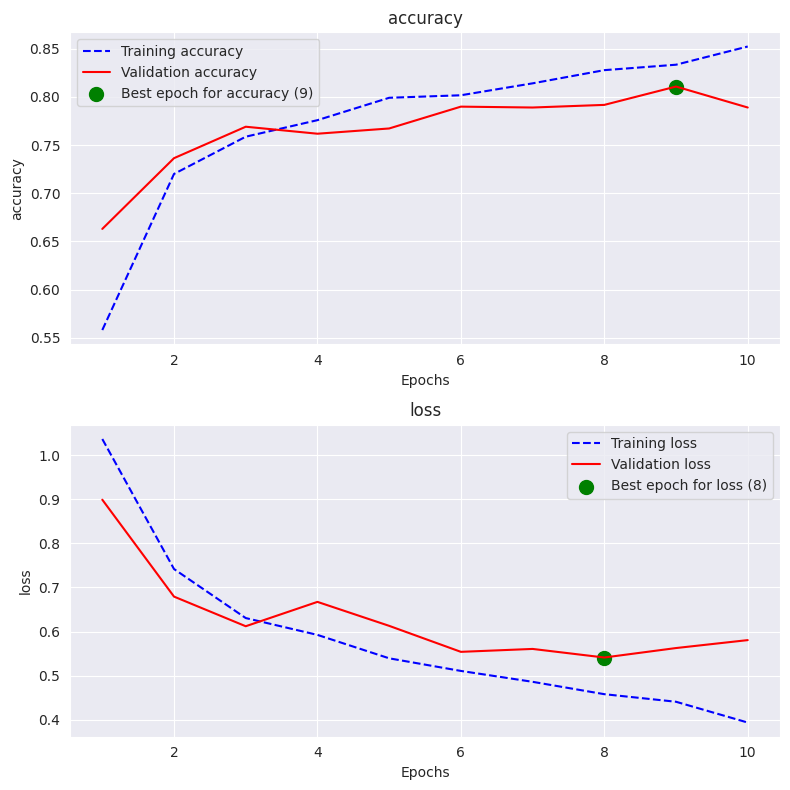

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


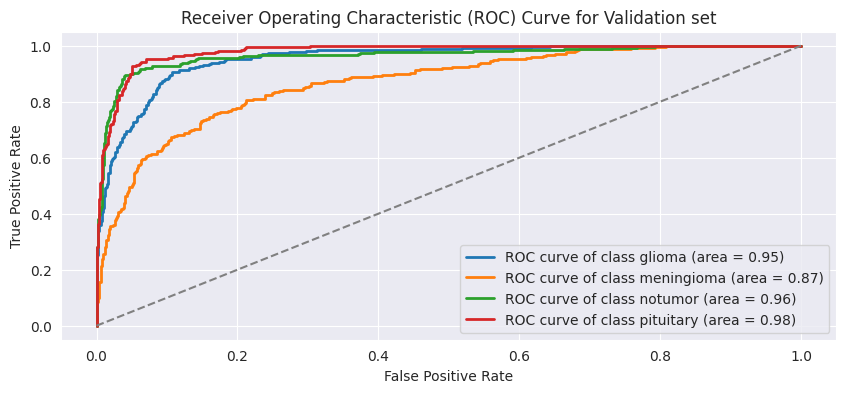

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


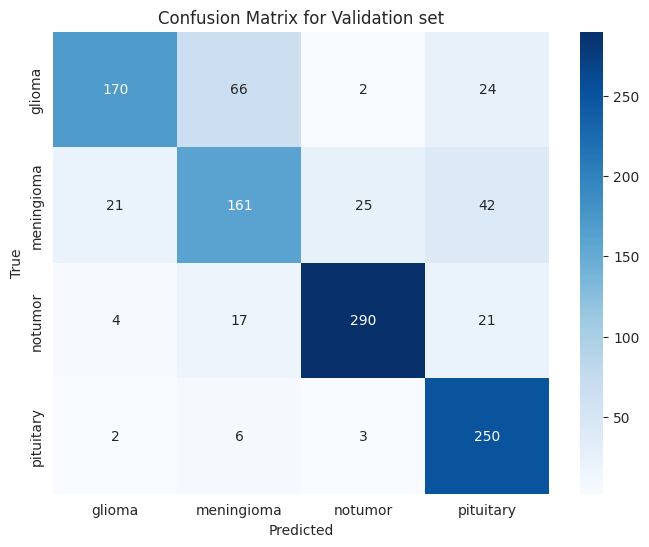

41/41 ━━━━━━━━━━━━━━━━━━━━ -2s -57387us/step


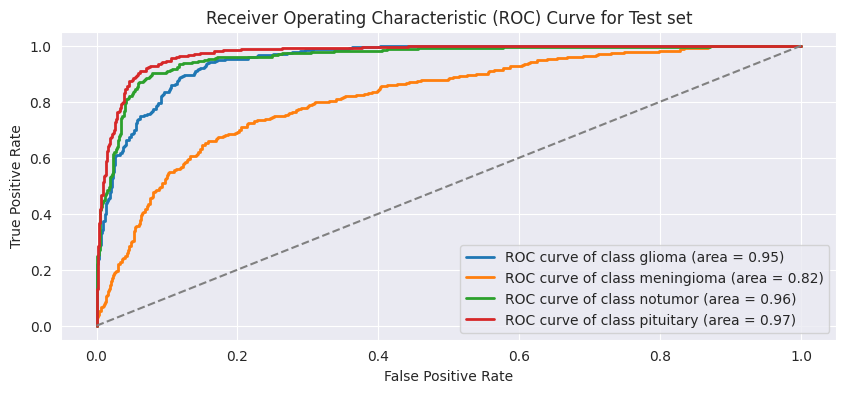

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


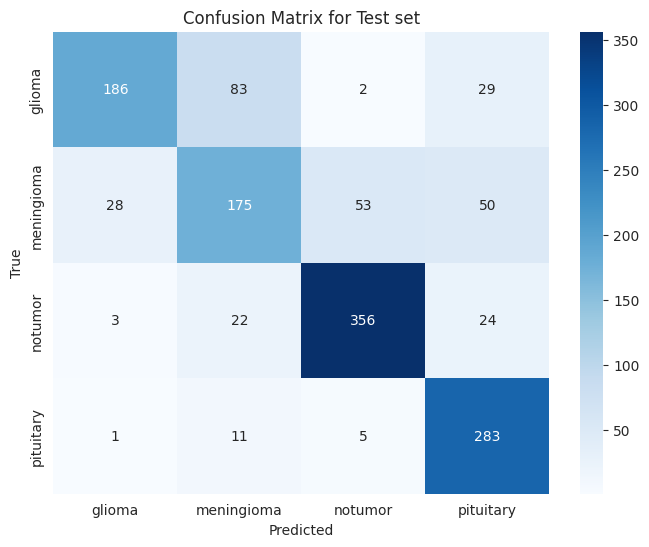

In [9]:
summarize_metric(history)

plot_roc_curve(base, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(base, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')

plot_roc_curve(base, X_test, y_test, class_names_test, title = 'Test set')
plot_confusion_matrix(base, X_test, y_test, class_names_test, normalize=False, title = 'Test set')

In [10]:
models = [base]

metrics, f1 = get_metrics(models, X_test, y_test, class_names_test)
display(metrics.rename(columns = {0: "Baselinemodel"}))
display(f1.rename(columns = {0: "F1"}))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - F1Score: 0.4499 - accuracy: 0.6683 - gioma_precision: 0.9217 - gioma_recall: 0.5757 - loss: 0.8855 - meningioma_precision: 0.4617 - meningioma_recall: 0.4005 - notumor_precision: 0.4309 - notumor_recall: 0.4677 - pituitary_precision: 0.1475 - pituitary_recall: 0.2426                   


,Baselinemodel
accuracy,0.762776
gioma_precision,0.871134
gioma_recall,0.563333
meningioma_precision,0.618321
meningioma_recall,0.529412
notumor_precision,0.864865
notumor_recall,0.869136
pituitary_precision,0.752000
pituitary_recall,0.940000


,F1
glioma,0.718147
meningioma,0.586265
notumor,0.867235
pituitary,0.825073


# Convolutional Neural Network (Hyperparameter optimized)

In [26]:
cnn = cnn300k()

cnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 30, 30, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 30, 30, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 30, 30, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 15, 15, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 15, 15, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 15, 15, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 15, 15, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 308,900 (1.18 MB)

 Trainable params: 308,420 (1.18 MB)

 Non-trainable params: 480 (1.88 KB)

In [27]:
early_stopping = callbacks.EarlyStopping(monitor= 'val_loss', patience = 10, start_from_epoch= 20, restore_best_weights= True)
cnnhistory = cnn.fit(X_train, y_train, batch_size =4, epochs = 50, validation_data = (X_val, y_val), verbose = 1, callbacks= early_stopping)

Epoch 1/50
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - F1Score: 0.4108 - accuracy: 0.4361 - gioma_precision: 0.6479 - gioma_recall: 0.4719 - loss: 1.3449 - meningioma_precision: 0.6474 - meningioma_recall: 0.2611 - notumor_precision: 0.7603 - notumor_recall: 0.6152 - pituitary_precision: 0.7144 - pituitary_recall: 0.5425 - val_F1Score: 0.5949 - val_accuracy: 0.6087 - val_gioma_precision: 0.8269 - val_gioma_recall: 0.1641 - val_loss: 0.8960 - val_meningioma_precision: 0.4232 - val_meningioma_recall: 0.5422 - val_notumor_precision: 0.8653 - val_notumor_recall: 0.6386 - val_pituitary_precision: 0.8832 - val_pituitary_recall: 0.4636
Epoch 2/50
1152/1152 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - F1Score: 0.5722 - accuracy: 0.5855 - gioma_precision: 0.5640 - gioma_recall: 0.2808 - loss: 0.9676 - meningioma_precision: 0.4296 - meningioma_recall: 0.1496 - notumor_precision: 0.7854 - notumor_recall: 0.5642 - pituitary_precision: 0.7783 - pituitary_recall: 0.6116 - val_F1Score: 0.6797 - val_accuracy:

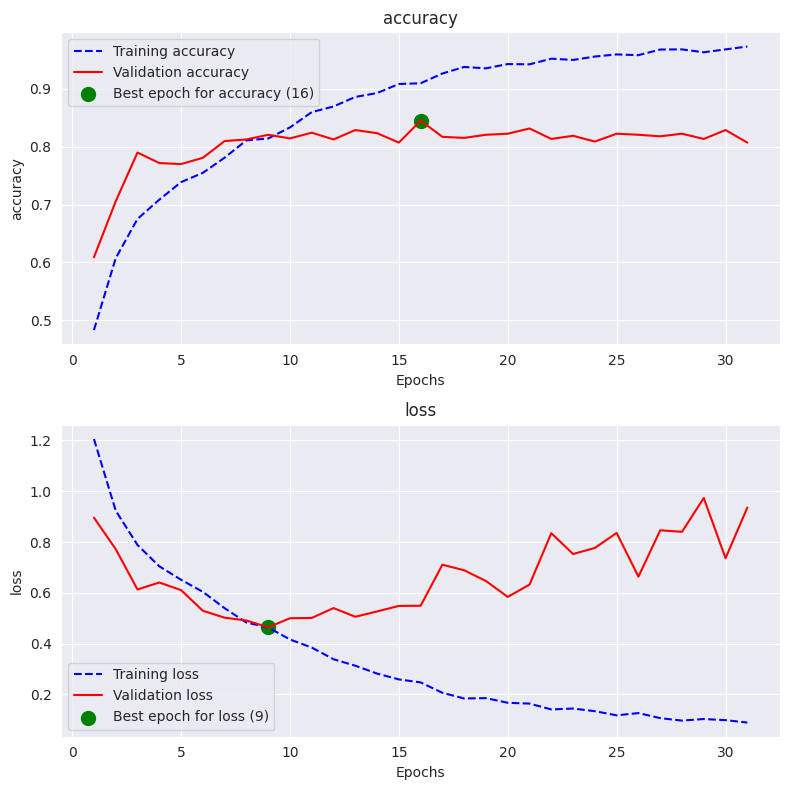

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


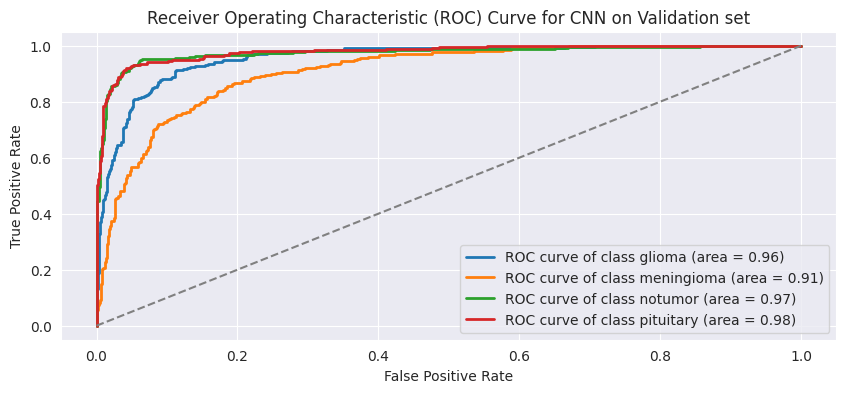

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


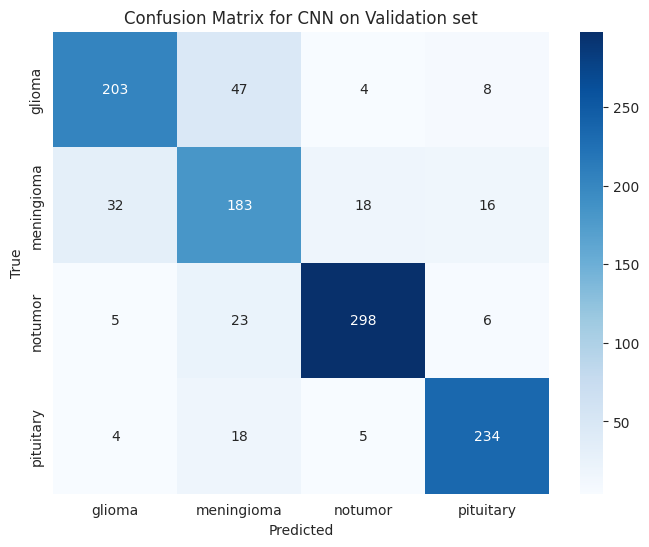

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


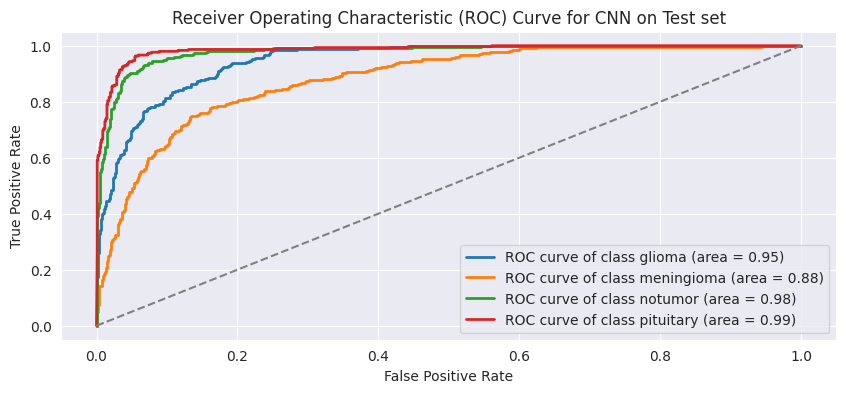

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


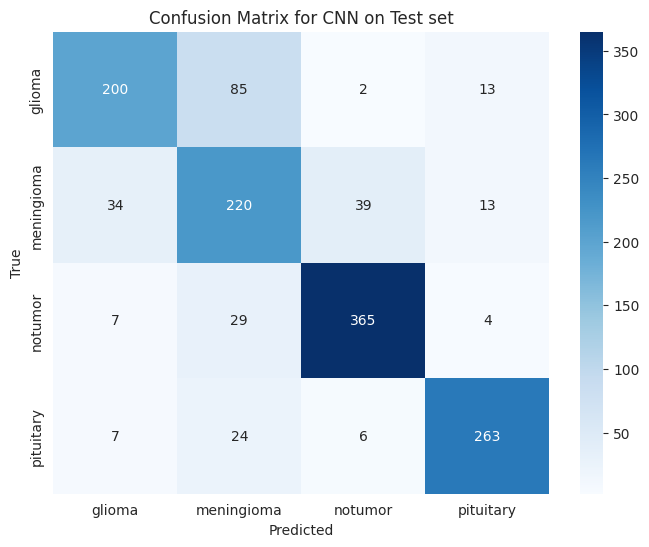

In [30]:
summarize_metric(cnnhistory)

plot_roc_curve(cnn, X_val, y_val, class_names_train, title= 'CNN on Validation set')
plot_confusion_matrix(cnn, X_val, y_val, class_names_train, normalize=False, title = 'CNN on Validation set')

plot_roc_curve(cnn, X_test, y_test, class_names_test, title = 'CNN on Test set')
plot_confusion_matrix(cnn, X_test, y_test, class_names_test, normalize=False, title = 'CNN on Test set')

# Transfer learning

### VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

resolution=32

vgg16_model = transfer_learning(VGG16, resolution,X_train, y_train, X_val, y_val, epochs=30, batch_size=32, optimizer = "adam")

plot_roc_curve(vgg16_model, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(vgg16_model, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')


In [ ]:
# VGG16 with two dense 
resolution=32

vgg16_model1 = transfer_learning(VGG16, resolution,X_train, y_train, X_val, y_val, epochs=30, batch_size=32, optimizer = "adam", add_extra_layer=True)

plot_roc_curve(vgg16_model1, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(vgg16_model1, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')


### Resnet50

In [ ]:
from tensorflow.keras.applications import ResNet50

resolution=32

resnet_model = transfer_learning(ResNet50, resolution,X_train, y_train, X_val, y_val, epochs=30, batch_size=32, optimizer = "adam")

plot_roc_curve(resnet_model, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(resnet_model, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')


In [ ]:
# Resnet50 with two dense layers

resolution=32

resnet_model1 = transfer_learning(ResNet50, resolution,X_train, y_train, X_val, y_val, epochs=30, batch_size=32, optimizer = "adam", add_extra_layer=True)

plot_roc_curve(resnet_model1, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(resnet_model1, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')


### Densenet 

In [ ]:
from tensorflow.keras.applications import DenseNet121

resolution=32

densenet_model = transfer_learning(DenseNet121, resolution,X_train, y_train, X_val, y_val, epochs=30, batch_size=32, optimizer = "adam")

plot_roc_curve(densenet_model, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(densenet_model, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')


In [ ]:
# Densenet with two dense layers
resolution=32

densenet_model1 = transfer_learning(DenseNet121, resolution,X_train, y_train, X_val, y_val, epochs=30, batch_size=32, optimizer = "adam", add_extra_layer=True)

plot_roc_curve(densenet_model1, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(densenet_model1, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')


### EfficientNet

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

resolution=32

efficientnet_model = transfer_learning(EfficientNetB0, resolution,X_train, y_train, X_val, y_val, epochs=30, batch_size=32, optimizer = "adam")

plot_roc_curve(efficientnet_model, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(efficientnet_model, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')


### EfficientNet80B with two dense layers

In [ ]:
resolution=32

efficientnet_model1 = transfer_learning(EfficientNetB0, resolution,X_train, y_train, X_val, y_val, epochs=30, batch_size=32, optimizer = "adam", add_extra_layer=True)

plot_roc_curve(efficientnet_model1, X_val, y_val, class_names_train, title = 'Validation set')
plot_confusion_matrix(efficientnet_model1, X_val, y_val, class_names_train, normalize=False, title = 'Validation set')


## Transfer learning results (without any finetuning)

In [ ]:
models = [vgg16_model, resnet_model, densenet_model, efficientnet_model, vgg16_model1, resnet_model1, densenet_model1, efficientnet_model1]

metrics, f1 = get_metrics(models, X_val, y_val, class_names_train)
display(metrics.rename(columns = {0: "VGG16", 1: "Resnet50", 2: "Densenet121", 3: "EfficientNetB0", 4: "VGG16 (2 layers)", 5: "Resnet50 (2 layers)", 6: "Densenet121 (2 layers)", 7: "EfficientNetB0 (2 layers)"}))
display(f1.rename(columns =  {0: "VGG16", 1: "Resnet50", 2: "Densenet121", 3: "EfficientNetB0", 4: "VGG16 (2 layers)", 5: "Resnet50 (2 layers)", 6: "Densenet121 (2 layers)", 7: "EfficientNetB0 (2 layers)"}))

# Custom model with VGG16 initial weights and convolution blocks
During transfer learning we noticed that the shallow networks work best and we can further improve accuracy by adding a few convolution blocks at the end of the first few layers of VGG16, this helps in capturing the general features from pretrained model and train the model to our special domain

In [14]:
custom_vgg = custom_vgg16()
early_stopping = callbacks.EarlyStopping(monitor= 'val_loss', patience = 3, start_from_epoch= 8, restore_best_weights= True)
vgg_history = custom_vgg.fit(X_train, y_train, epochs = 30, validation_data = (X_val, y_val), verbose = 1, callbacks= early_stopping)

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,735,488 (6.62 MB)

 Trainable params: 1,735,488 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 30, 30, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 30, 30, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_24 (Functional)      │ (None, 4, 4, 256)      │     1,735,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 32)       │        73,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,822,708 (6.95 MB)

 Trainable params: 1,822,708 (6.95 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
141/144 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - F1Score: 0.2582 - accuracy: 0.2921 - gioma_precision: 0.7087 - gioma_recall: 0.2975 - loss: 2.8120 - meningioma_precision: 0.6003 - meningioma_recall: 0.2923 - notumor_precision: 0.8320 - notumor_recall: 0.4535 - pituitary_precision: 0.7535 - pituitary_recall: 0.3852

W0000 00:00:1727617849.692033   58468 assert_op.cc:38] Ignoring Assert operator functional_25_1/lambda_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1727617849.693509   58468 assert_op.cc:38] Ignoring Assert operator functional_25_1/lambda_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert
W0000 00:00:1727617851.811515   58461 assert_op.cc:38] Ignoring Assert operator functional_25_1/lambda_1/grayscale_to_rgb/assert_equal_1/Assert/Assert
W0000 00:00:1727617851.811642   58461 assert_op.cc:38] Ignoring Assert operator functional_25_1/lambda_1/grayscale_to_rgb/assert_greater_equal/Assert/Assert


144/144 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - F1Score: 0.2599 - accuracy: 0.2943 - gioma_precision: 0.7086 - gioma_recall: 0.2935 - loss: 2.7800 - meningioma_precision: 0.6001 - meningioma_recall: 0.2883 - notumor_precision: 0.8308 - notumor_recall: 0.4522 - pituitary_precision: 0.7530 - pituitary_recall: 0.3814 - val_F1Score: 0.4214 - val_accuracy: 0.5072 - val_gioma_precision: 0.0000e+00 - val_gioma_recall: 0.0000e+00 - val_loss: 1.0930 - val_meningioma_precision: 0.7143 - val_meningioma_recall: 0.0201 - val_notumor_precision: 0.7935 - val_notumor_recall: 0.7410 - val_pituitary_precision: 1.0000 - val_pituitary_recall: 0.0192
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - F1Score: 0.5942 - accuracy: 0.6217 - gioma_precision: 0.4904 - gioma_recall: 0.1759 - loss: 0.9357 - meningioma_precision: 0.7014 - meningioma_recall: 0.1828 - notumor_precision: 0.8397 - notumor_recall: 0.6914 - pituitary_precision: 0.7448 - pituitary_recall: 0.6173 - val_F1Score: 0.6172 - val_accuracy: 0.66

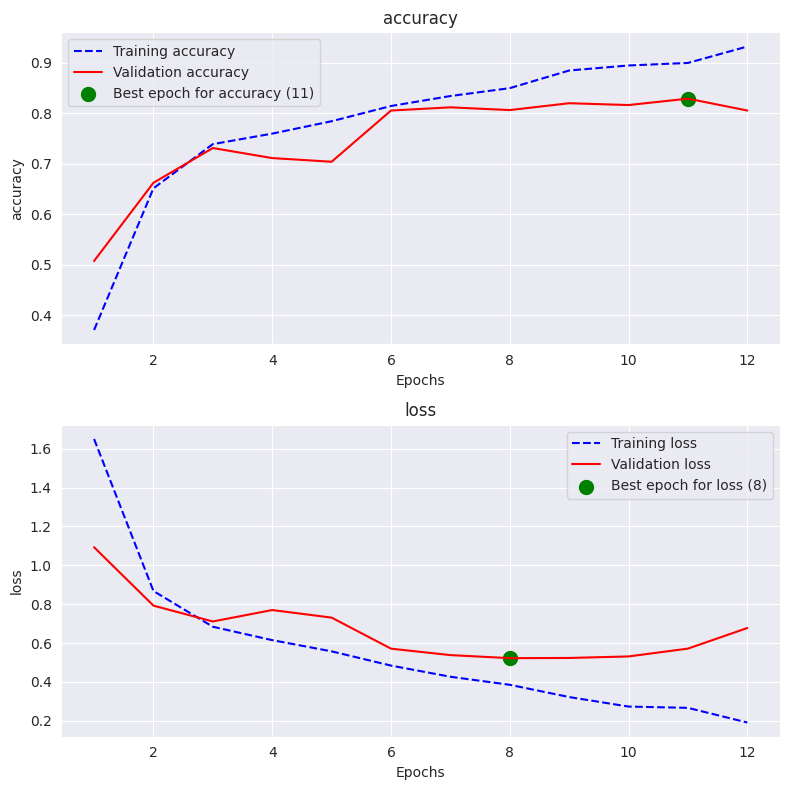

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


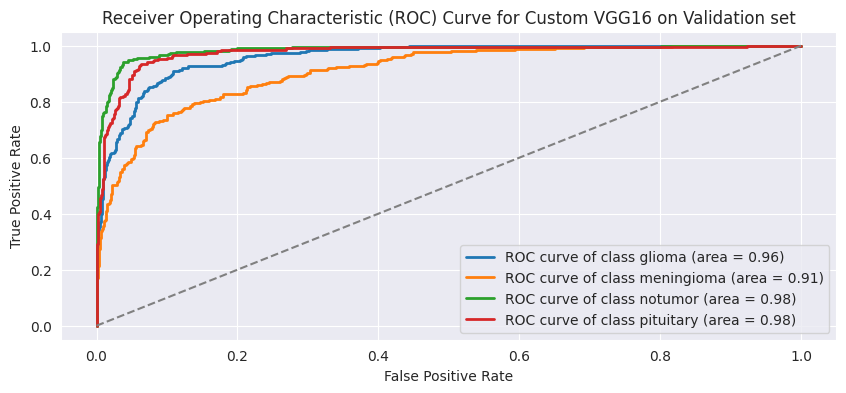

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


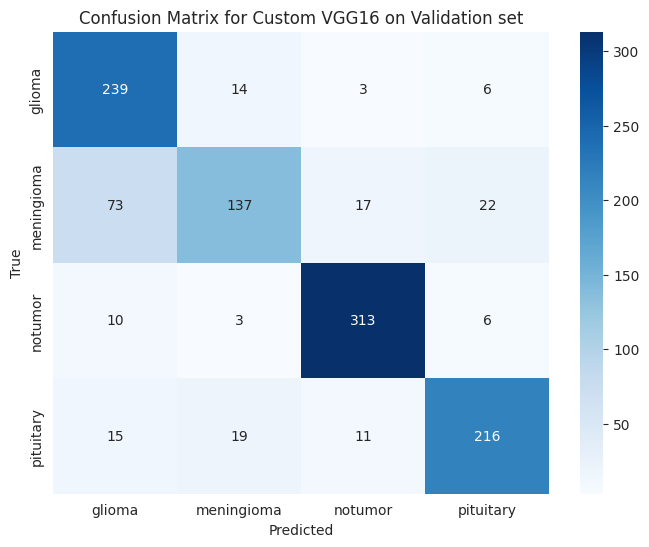

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


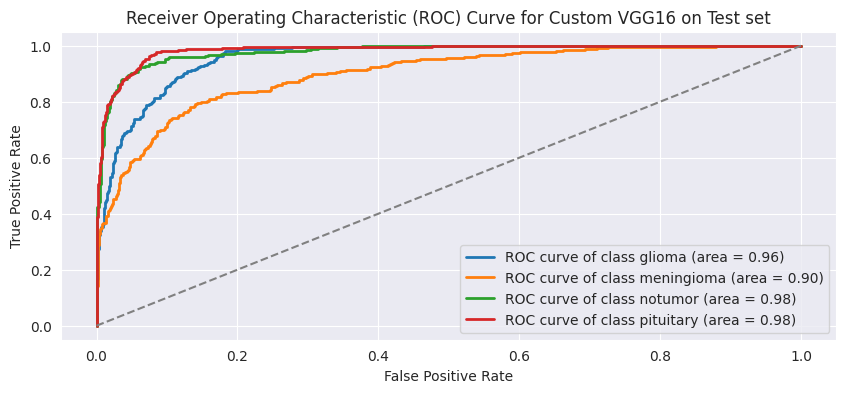

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


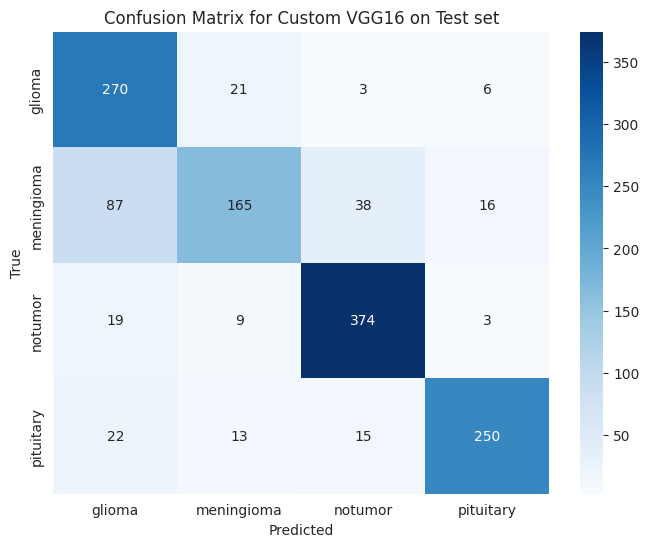

In [17]:
summarize_metric(vgg_history)

plot_roc_curve(custom_vgg, X_val, y_val, class_names_train, title= 'Custom VGG16 on Validation set')
plot_confusion_matrix(custom_vgg, X_val, y_val, class_names_train, normalize=False, title = 'Custom VGG16 on Validation set')

plot_roc_curve(custom_vgg, X_test, y_test, class_names_test, title = 'Custom VGG16 on Test set')
plot_confusion_matrix(custom_vgg, X_test, y_test, class_names_test, normalize=False, title = 'Custom VGG16 on Test set')

# Final Model Comparison

In [29]:
models = [base, cnn, custom_vgg]

metrics, f1 = get_metrics(models, X_test, y_test, class_names_test)
display(metrics.rename(columns = {0: "Baselinemodel", 1: "CNN300k", 2: "Custom VGG16"}))
display(f1.rename(columns = {0: "Baselinemodel F1", 1: "CNN300k F1", 2: "Custom VGG16 F1"}))

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - F1Score: 0.4499 - accuracy: 0.6683 - gioma_precision: 0.9217 - gioma_recall: 0.5757 - loss: 0.8855 - meningioma_precision: 0.4617 - meningioma_recall: 0.4005 - notumor_precision: 0.4309 - notumor_recall: 0.4677 - pituitary_precision: 0.1475 - pituitary_recall: 0.2426                
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - F1Score: 0.4893 - accuracy: 0.7377 - gioma_precision: 0.8953 - gioma_recall: 0.6800 - loss: 0.7464 - meningioma_precision: 0.4875 - meningioma_recall: 0.5541 - notumor_precision: 0.4543 - notumor_recall: 0.5042 - pituitary_precision: 0.1981 - pituitary_recall: 0.2214                
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - F1Score: 0.5129 - accuracy: 0.8200 - gioma_precision: 0.8285 - gioma_recall: 0.8911 - loss: 0.4912 - meningioma_precision: 0.6506 - meningioma_recall: 0.4342 - notumor_precision: 0.4529 - notumor_recall: 0.5009 - pituitary_precision: 0.2061 - pituitary_recall: 0.2088                


,Baselinemodel,CNN300k,Custom VGG16
accuracy,0.762776,0.799390,0.807780
gioma_precision,0.871134,0.805668,0.697368
gioma_recall,0.563333,0.663333,0.883333
meningioma_precision,0.618321,0.632948,0.826531
meningioma_recall,0.529412,0.715686,0.529412
notumor_precision,0.864865,0.894349,0.874408
notumor_recall,0.869136,0.898765,0.911111
pituitary_precision,0.752000,0.899306,0.917910
pituitary_recall,0.940000,0.863333,0.820000


,Baselinemodel F1,CNN300k F1,Custom VGG16 F1
glioma,0.718147,0.729927,0.773639
meningioma,0.586265,0.662651,0.642023
notumor,0.867235,0.893513,0.895808
pituitary,0.825073,0.887015,0.869565


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


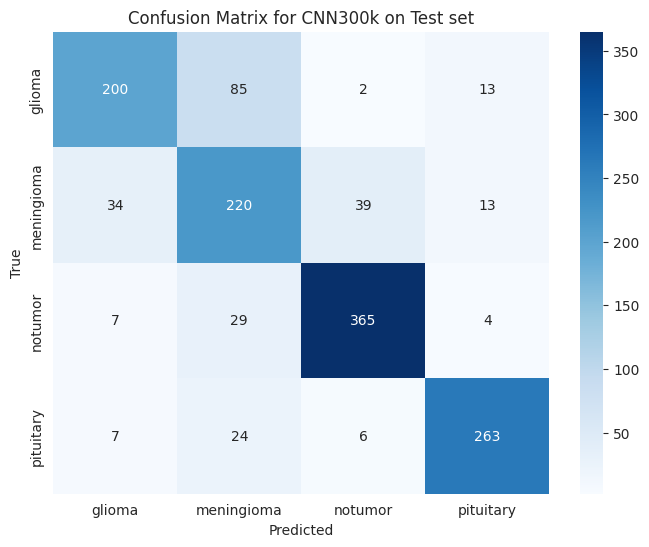

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


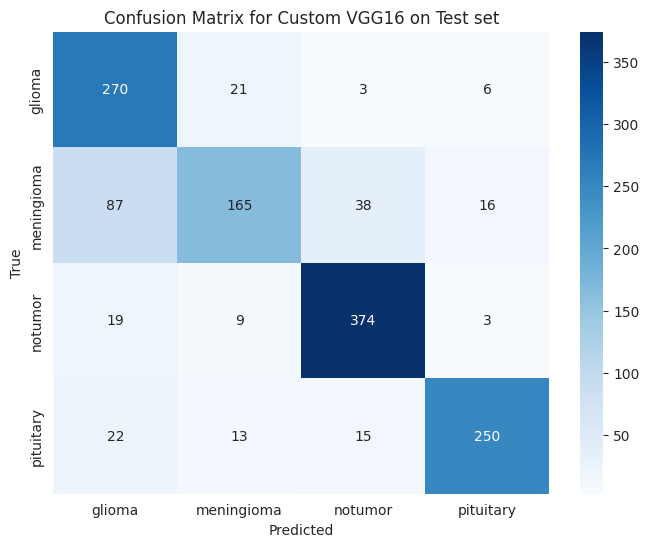

In [33]:
plot_confusion_matrix(cnn, X_test, y_test, class_names_test, normalize=False, title = 'CNN300k on Test set')
plot_confusion_matrix(custom_vgg, X_test, y_test, class_names_test, normalize=False, title = 'Custom VGG16 on Test set')